## Exploring Malaria Simulation Output Data

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

strategies = ['status_quo',
              'AL5',
              'AL4',
              'ASAQ',
              'ASAQ25-DHA-PPQ75',
              'AL75-ASAQ25',
              'AL25-DHA-PPQ75',
              'AL25-ASAQ75',
              'ASAQ50-DHA-PPQ50',
              'AL50-DHA-PPQ50',
              'DHA-PPQ',
              'AL75-DHA-PPQ25']

table_names = ['monthlydata', 'sqlite_sequence', 'monthlysitedata', 'genotype', 'monthlygenomedata']
 
def get_all_tables(db: str) -> list:
    """
    Get all tables in a sqlite3 database

    Args:
    db (str): path to sqlite3 database

    Returns:
    list: list of tables in the database
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        c = conn.cursor()
        c.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = c.fetchall()
    
    return [table[0] for table in tables]

def get_table(db: str, table: str) -> pd.DataFrame:
    """
    Get a table from a sqlite3 database

    Args:
    db (str): path to sqlite3 database
    table (str): name of table to get

    Returns:
    pd.DataFrame: table as a pandas DataFrame
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    
    return df

def calculate_treatment_failure_rate(data: pd.DataFrame, locationid: int = 0) -> pd.DataFrame:
    """
    Calculate treatment failures for a given table

    Args:
    data (DataFrame): monthlysitedata table to calculate treatment failures
    locationid (int): locationid to filter by

    Returns:
    pd.DataFrame: table with treatment failures
    """
    # Calculate treatment failures
    if locationid > 0:
        data = data[data["locationid"] == locationid]
    data['failure_rate'] = data['treatmentfailures'] / data['treatments']

    return data

def aggregate_monthlysitedata(path: str, strategy: str, locationid: int = 0) -> pd.DataFrame:
    """
    Aggregate data by strategy. This function searchs path for all the result files for the given strategy and aggregates them.

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for

    Returns:
    pd.DataFrame: aggregated data
    pd.Series: monthlydataid column
    """
    # Get all files for the strategy
    files = glob.glob(os.path.join(f"{path}", f"*_{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy} in {path}")
        return
    else:
        print(f"Aggregating data for strategy {strategy} with {len(files)} files")
    # Get the monthlysitedata table for the first file to set up aggregated data
    monthlysitedata_columns = get_table(files[0], 'monthlysitedata').columns.to_list()
    monthlysitedata_columns.remove('monthlydataid')
    monthlysitedata_columns.append('failure_rate')
    monthlysitedata = {column : pd.DataFrame() for column in monthlysitedata_columns}    
    # Aggregate data for the rest of the files
    for file in files:
        # print(f"Aggregating data for {file}")
        data = get_table(file, 'monthlysitedata')
        if locationid > 0:
            data = data[data["locationid"] == locationid]
        if 'failure_rate' not in data.columns:
            data = calculate_treatment_failure_rate(data)
        monthlydataid = data['monthlydataid']
        for column in monthlysitedata_columns:            
            if column != 'monthlydataid':                
                monthlysitedata[column] = pd.concat([monthlysitedata[column], data[column]], axis=1)
    # Calculate statistics for the aggregated data
    for column in monthlysitedata_columns:
        if column != 'monthlydataid':
            monthlysitedata[column]['mean'] = monthlysitedata[column].mean(axis=1)
            monthlysitedata[column]['median'] = monthlysitedata[column].median(axis=1)
            monthlysitedata[column]['95th'] = monthlysitedata[column].quantile(axis=1, q=0.95)
            monthlysitedata[column]['5th'] = monthlysitedata[column].quantile(axis=1, q=0.05)           
            
    return monthlysitedata, monthlydataid

def save_aggregated_data(monthlysitedata: dict[str, pd.DataFrame], monthlydataid: pd.Series, strategy: str, path: str):
    """
    Save aggregated data to a file

    Args:
    monthlysitedata (dict[str, pd.DataFrame]): aggregated data
    monthlydataid (pd.Series): monthlydataid column
    strategy (str): strategy
    path (str): path to save the file
    """
    with sqlite3.connect(os.path.join(path, f"{strategy}_aggregated.db")) as conn:
        for column in monthlysitedata.keys():
            monthlysitedata[column].to_sql(column, conn, index=False)
        monthlydataid.to_sql('monthlydataid', conn, index=False)

def plot_strategy_treatment_failure(data: pd.DataFrame, months: pd.DataFrame, strategy: str, figsize: tuple = (18, 3)):
    """
    Plot treatment failure rate for a given strategy

    Args:
        data (pd.DataFrame): treatement failure data to plot
        months (pd.DataFrame): months for the data
        strategy (str): strategy to plot
        figsize (tuple): figure size
    
    Returns:    
        tuple: figure and axis
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(months / 12, data['failure_rate']['mean'], label='Mean')
    ax.fill_between(months / 12, data['failure_rate']['5th'], data['failure_rate']['95th'], color='b', alpha=0.15, label='5th-95th percentile')
    ax.axhline(y=0.1, color='r', linestyle='--', label='10% threshold')
    ax.set_title(f"{strategy} Treatment Failure Rate")
    ax.set_xlabel("Years")
    ax.set_ylabel("Treatment Failure Rate")
    ax.legend()
    return fig, ax

def aggregate_treatment_failures_for_strategies(path: str, strategies: list[str], locationid: int = 0) -> dict[str, pd.DataFrame]:
    """
    Aggregate treatment failures for all strategies

    Args:
    path (str): path to search for result files
    strategies (list): list of strategies to aggregate data for

    Returns:
    dict: dictionary of aggregated dataframes
    """
    aggregated_data = {}
    for strategy in strategies:
        print(f"Aggregating data for {strategy}")
        try:
            data, months = aggregate_monthlysitedata(path, strategy, locationid)
        except TypeError as e:
            print(e)
            continue
        except FileNotFoundError as e:
            print(e)
            continue
        try:
            months = months.to_numpy()
            aggregated_strategy_data = pd.DataFrame.from_dict({
                'months': months,
                'mean': data['failure_rate']['mean'],
                'median': data['failure_rate']['median'],
                '5th': data['failure_rate']['5th'],
                '95th': data['failure_rate']['95th']
            })
        except KeyError as e:
            print(e)
            continue
        except ValueError as e:
            print(e)
            continue
        aggregated_strategy_data.index = aggregated_strategy_data['months']
        aggregated_data[strategy] = aggregated_strategy_data
    return aggregated_data

In [2]:
#DATA_ROOT: str = os.path.join("G:\\", "My Drive")
DATA_ROOT: str = os.path.join("/", "home", "james")
DATA_SOURCE: str = os.path.join(DATA_ROOT, "Desktop", "output_old")

In [10]:
title:str = "status_quo"

In [12]:
title.title().replace("_", " ")

'Status Quo'

Aggregating data for strategy status_quo with 11 files
Aggregating data for strategy AL5 with 10 files
No files found for strategy AL4 in /home/james/Desktop/output_old
cannot unpack non-iterable NoneType object
Aggregating data for strategy ASAQ with 5 files
x and y must have same first dimension, but have shapes (0,) and (2,)
Aggregating data for strategy ASAQ25-DHA-PPQ75 with 11 files
Aggregating data for strategy AL75-ASAQ25 with 6 files
Aggregating data for strategy AL25-DHA-PPQ75 with 11 files
Aggregating data for strategy AL25-ASAQ75 with 3 files
Aggregating data for strategy ASAQ50-DHA-PPQ50 with 4 files
x and y must have same first dimension, but have shapes (335,) and (385,)
Aggregating data for strategy AL50-DHA-PPQ50 with 2 files
x and y must have same first dimension, but have shapes (292,) and (385,)
Aggregating data for strategy DHA-PPQ with 6 files
x and y must have same first dimension, but have shapes (113,) and (114,)
Aggregating data for strategy AL75-DHA-PPQ25 with

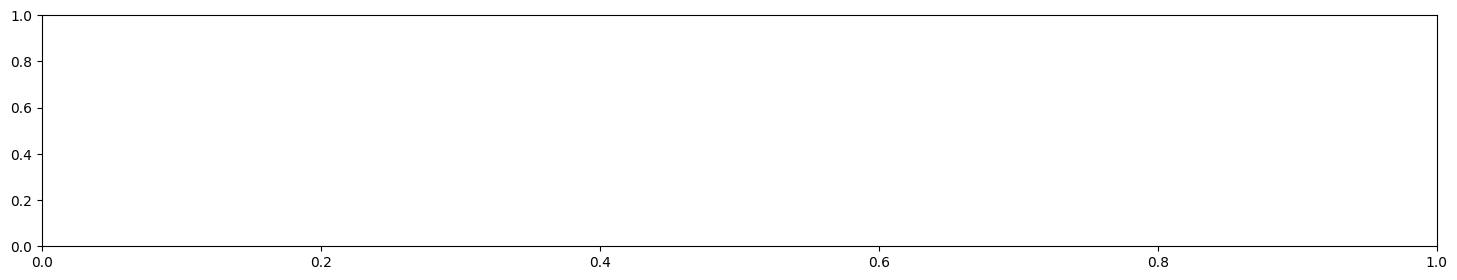

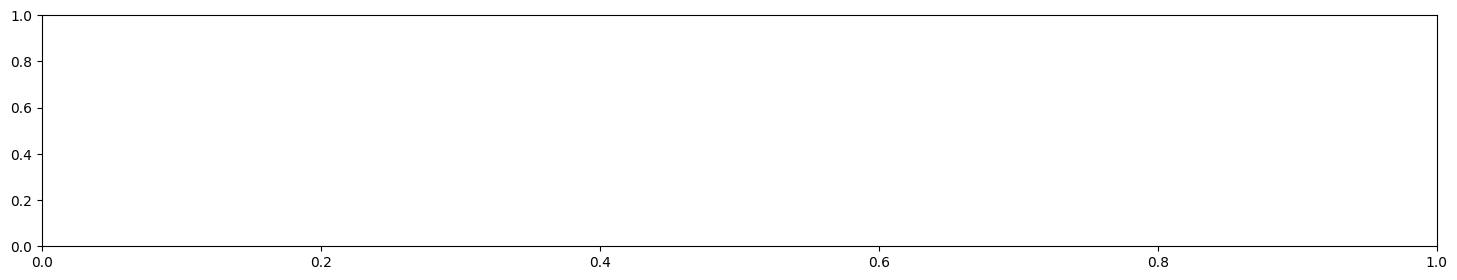

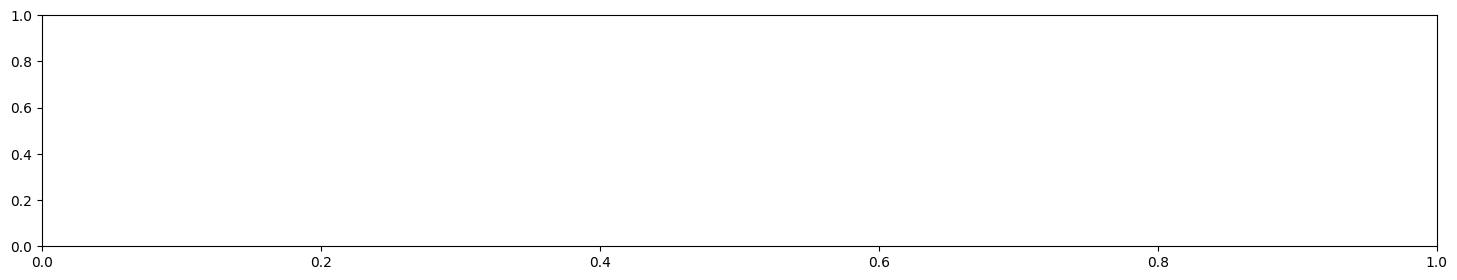

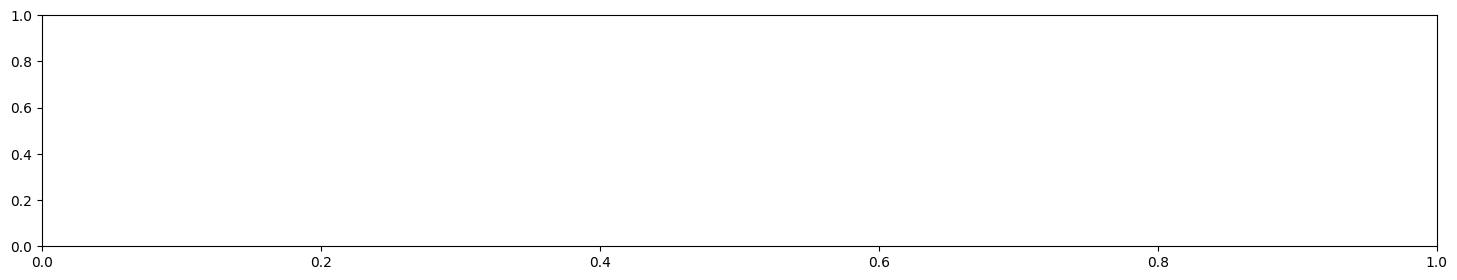

In [ ]:
for strategy in strategies:
    try:
        data, months = aggregate_monthlysitedata(DATA_SOURCE, strategy, 1)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    try:
        fig, ax = plot_strategy_treatment_failure(data, months, strategy.replace("_", " ").title())
    except ValueError as e:
        print(e)
        continue
    plt.savefig(f"{strategy}.png")
    plt.close(fig)

In [15]:
months

Series([], Name: monthlydataid, dtype: object)

In [6]:
aggregated_tf = aggregate_treatment_failures_for_strategies(DATA_SOURCE, strategies, 1)

Aggregating data for status_quo
Aggregating data for strategy status_quo with 11 files
Aggregating data for AL5
Aggregating data for strategy AL5 with 10 files
Aggregating data for AL4
No files found for strategy AL4 in /home/james/Desktop/output_old
cannot unpack non-iterable NoneType object
Aggregating data for ASAQ
Aggregating data for strategy ASAQ with 5 files
array length 0 does not match index length 2
Aggregating data for ASAQ25-DHA-PPQ75
Aggregating data for strategy ASAQ25-DHA-PPQ75 with 11 files
Aggregating data for AL75-ASAQ25
Aggregating data for strategy AL75-ASAQ25 with 6 files
Aggregating data for AL25-DHA-PPQ75
Aggregating data for strategy AL25-DHA-PPQ75 with 11 files
Aggregating data for AL25-ASAQ75
Aggregating data for strategy AL25-ASAQ75 with 3 files
Aggregating data for ASAQ50-DHA-PPQ50
Aggregating data for strategy ASAQ50-DHA-PPQ50 with 4 files
array length 335 does not match index length 385
Aggregating data for AL50-DHA-PPQ50
Aggregating data for strategy AL50

In [7]:
def plot_strategy_results(path: str, strategy: str, locationid:int = 0) -> plt.Figure:
    """
    Plots the treatment failure rate for a given strategy. If locationid is provided, only that location is plotted.
    If more than one results file is found in the path, the data is aggregated.

    Args:
    path (str): path to directory containing results files
    strategy (str): strategy to plot
    locationid (int): locationid to filter by

    Returns:
    plt.Figure: matplotlib figure
    """
    # Assert that the location is valid
    if locationid < 0:
        raise ValueError("locationid must be a positive integer")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    # Get all results files in the path
    results_files = glob.glob(os.path.join(path, f"*_{strategy}_.db"))
    if len(results_files) == 0:
        raise FileNotFoundError(f"No results files found for strategy {strategy}")
    # Read all results files
    failures = pd.DataFrame()
    for file in results_files:
        data = get_table(file, 'monthlysitedata')
        data = calculate_treatment_failure_rate(data, locationid)
        failures[file] = data['failure_rate']
        
    if locationid > 0:
        failures = failures.loc[failures['locationid'] == locationid]
    # else, aggregate all locations by taking the mean of the failure rates at each month
    else:
        months = failures['monthlydataid'].unique()
        monthly_average = pd.DataFrame()
        for month in months:
            monthly_data = failures.loc[failures['monthlydataid'] == month]
            monthly_average[month, 'population'] = monthly_data['population'].sum()
            monthly_average[month, 'treatments'] = monthly_data['treatments'].sum()
            monthly_average[month, 'treatmentfailures'] = monthly_data['treatmentfailures'].sum()
            monthly_average[month, 'failure_rate'] = monthly_data['failure_rate'].mean()

    failures['mean'] = failures.mean(axis=1)
    fig, ax = plt.subplots()
    ax.plot(failures['monthlydataid'])

In [8]:
def aggregate_genome_data(path: str, strategy: str) -> pd.DataFrame:
    """
    Aggregate genome data for a given strategy
    """
    # Get all results files in the path
    results_files = glob.glob(os.path.join(path, f"*_{strategy}_.db"))
    if len(results_files) == 0:
        raise FileNotFoundError(f"No results files found for strategy {strategy}")
    for file in results_files:
        genome_data = get_table(file, 'monthlygenomedata')
        population_data = get_table(file, 'monthlysitedata')
        genomes = get_table(file, 'genotype')

        months = genome_data['monthlydataid'].unique()
        pop = population_data.loc[population_data['monthlydataid'] == months[-1], ['population']].sum().to_numpy()
        for genome in genomes['genomeid']:
            genome_count = genome_data.loc[(genome_data['genomeid'] == genome) & 
                                           (genome_data['monthlydataid'] == months[-1]), 
                                           ['occurrences']].sum().to_numpy()
            
def calculate_genome_frequencies(genome_data: pd.DataFrame, populations: pd.DataFrame, genotypes: list[int] | pd.Series) -> pd.DataFrame:
    """
    Calculate genome frequencies for a given month. The genome_data DataFrame contains the number of occurrences of each genome
    for a given location and month. The population is the total population for the location and month.
    """
    genome_frequencies_counts = pd.DataFrame(index=populations['locationid'], columns=genotypes['id'].to_list())

    for genotype in genotypes['id']:
        genome_counts = genome_data.loc[genome_data['genomeid'] == genotype, ['occurrences']].to_numpy()
        genome_frequencies_counts[genotype] = genome_counts / populations['population'].to_numpy()

    return genome_frequencies_counts

In [85]:
fq = calculate_genome_frequencies(genome_data.loc[genome_data['monthlydataid'] == 385], population_data.loc[population_data['monthlydataid'] == 385], genomes)
fq

ValueError: Length of values (0) does not match length of index (30)

In [89]:
filelist = glob.glob(os.path.join(DATA_SOURCE, "*.db"))
genomes = get_table(filelist[0], 'genotype')
genome_data = get_table(filelist[0], 'monthlygenomedata')
genome_data = genome_data.loc[(genome_data['monthlydataid'] == 385)]
genome_data

,monthlydataid,locationid,genomeid,occurrences,clinicaloccurrences,occurrences0to5,occurrences2to10,weightedoccurrences
101418,385,1,0,275,14,53,68,251.333333
101419,385,1,2,529,23,99,144,470.416667
101420,385,1,4,3,0,0,0,3.000000
101421,385,1,6,1,0,1,1,0.500000
101422,385,1,8,6,1,1,1,6.000000
...,...,...,...,...,...,...,...,...
101894,385,30,38,18,0,4,5,17.000000
101895,385,30,40,144,7,37,41,132.000000
101896,385,30,42,315,14,66,77,286.166667
101897,385,30,48,308,15,70,84,284.833333


In [90]:
population_data = get_table(filelist[0], 'monthlysitedata')
population_data = population_data.loc[population_data['monthlydataid'] == 385]
population_data

,monthlydataid,locationid,population,clinicalepisodes,clinicalepisodes_by_age_class_0_1,clinicalepisodes_by_age_class_1_2,clinicalepisodes_by_age_class_2_3,clinicalepisodes_by_age_class_3_4,clinicalepisodes_by_age_class_4_5,clinicalepisodes_by_age_class_5_6,...,treatments,treatmentfailures,eir,pfprunder5,pfpr2to10,pfprall,infectedindividuals,nontreatment,under5treatment,over5treatment
11520,385,1,154167,2774,81,92,87,86,80,78,...,1719,141,0.570672,4.001499,3.781732,3.359344,9792,1055,216,1503
11521,385,2,172886,916,26,27,30,32,29,25,...,592,52,0.138291,1.015101,1.027770,0.982150,3469,324,72,520
11522,385,3,134118,2786,83,94,82,103,71,57,...,1805,156,0.704868,4.314025,4.191853,3.770560,9637,981,231,1574
11523,385,4,122769,1004,33,33,35,25,27,26,...,627,52,0.205539,1.463093,1.550418,1.514226,3621,377,83,544
11524,385,5,134112,581,12,25,18,13,19,14,...,368,32,0.102654,0.905369,0.867298,0.857492,2288,213,39,329
11525,385,6,153915,938,18,21,21,32,26,32,...,593,49,0.134282,1.126861,1.124366,1.149985,3442,345,63,530
11526,385,7,129835,2426,56,74,88,65,85,65,...,1500,109,0.574271,3.713151,3.548068,3.420495,8510,926,184,1316
11527,385,8,259459,4391,102,122,129,122,125,123,...,3104,287,0.493936,3.262378,3.249868,3.004714,14598,1287,341,2763
11528,385,9,34309,302,8,7,4,8,5,7,...,211,17,0.233669,1.241664,1.309891,1.442770,1004,91,21,190
11529,385,10,138356,1247,36,35,45,34,36,27,...,899,104,0.212385,1.668393,1.606432,1.577814,4171,348,106,793


In [91]:
genome_frequencies_counts = pd.DataFrame(index=population_data['locationid'], columns=genomes['id'].to_list())

In [93]:
id = 32
genome_frequencies_counts[id] = genome_data['occurrences'].to_numpy() / population_data['population'].to_numpy()

ValueError: operands could not be broadcast together with shapes (481,) (30,) 

In [94]:
genome_frequencies_counts[[31, 32, 33]]

,31,32,33
locationid,,,
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


In [48]:
genomes

,id,name
0,0,KNY--R1
1,1,KNY--R2
2,2,KNY--H1
3,3,KNY--H2
4,4,KYY--R1
...,...,...
59,59,TNFNFH2
60,60,TYFYFR1
61,61,TYFYFR2
62,62,TYFYFH1
